In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-31"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

np.save("data/btc_1m.npy", candles)

(2846880, 6)


In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles = candles[candles[:, 5] > 0]
print(candles.shape)
candles[0, 0]


(2846715, 6)


1577836800000.0

In [2]:
import os

import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

df = numpy_candles_to_dataframe(candles)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
# df["hlr_log"] = np.log(df["hlr"] + 1)
# df["hlr_sqrt"] = np.sqrt(df["hlr"] + 1) - 1

RANGE = [5, 10, 25, 50, 75, 100, 125, 150]

# abs return
ret_list = []
for i in RANGE:
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# # log return
# log_list = []
# for i in RANGE:
#     log_series = np.log(df[f"r{i}"] + 1)
#     log_series.name = f"r{i}_log"
#     log_list.append(log_series)
#
# # sqrt return
# sqrt_list = []
# for i in RANGE:
#     sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
#     sqrt_series.name = f"r{i}_sqrt"
#     sqrt_list.append(sqrt_series)

# entropy
entropy_list = []
for i in RANGE[2:]:
    log_ret_list = log_ret(candles, [i] * len(candles))
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    entropy_series = pd.Series(entropy_array, index=df.index)
    entropy_series.name = f"r{i}_entropy"
    entropy_list.append(entropy_series)

df = pd.concat(
    [
        df,
        # pd.concat(log_list, axis=1),
        # pd.concat(sqrt_list, axis=1),
        pd.concat(entropy_list, axis=1),
    ],
    axis=1,
)
del entropy_list


In [3]:
# data cleaning
na_max = df.isna().sum().max()
df = df.iloc[na_max:]
del candles
print(df.shape)

print(df.isna().sum().max())
df.head()


(2846565, 22)
1


,date,open,close,high,low,volume,label,hlr,r5,r10,...,r75,r100,r125,r150,r25_entropy,r50_entropy,r75_entropy,r100_entropy,r125_entropy,r150_entropy
2020-01-01 02:30:00,2020-01-01 02:30:00,7221.59,7227.00,7227.79,7221.59,82.247,-0.000018,0.000858,0.000720,0.000969,...,0.005687,0.006817,0.007178,0.006185,0.200671,0.168884,0.090684,0.055175,0.044477,0.034509
2020-01-01 02:31:00,2020-01-01 02:31:00,7226.96,7226.87,7227.73,7223.93,118.737,-0.000143,0.000526,0.000567,0.000579,...,0.005671,0.006983,0.007284,0.006645,0.210721,0.172914,0.092568,0.057110,0.046081,0.035480
2020-01-01 02:32:00,2020-01-01 02:32:00,7226.06,7225.84,7226.13,7224.90,53.181,0.000195,0.000170,-0.000281,0.001112,...,0.005529,0.007356,0.007340,0.006652,0.270646,0.185109,0.094245,0.061849,0.049649,0.037777
2020-01-01 02:33:00,2020-01-01 02:33:00,7225.97,7227.25,7230.17,7224.78,100.884,0.000159,0.000746,-0.000199,0.000903,...,0.005724,0.007484,0.007681,0.006405,0.269920,0.193260,0.094383,0.061849,0.050010,0.038144
2020-01-01 02:34:00,2020-01-01 02:34:00,7226.88,7228.40,7228.44,7224.80,67.185,0.000112,0.000504,0.000955,0.000657,...,0.005655,0.007731,0.007783,0.007380,0.287682,0.168846,0.101039,0.063480,0.051519,0.039290


In [4]:
data_check = np.load("data/btc_1m.npy")
data_check = data_check[data_check[:, 5] > 0]
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[150:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [5]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [6]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [11]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from jesse.helpers import date_to_timestamp
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum


def get_kurtosis(merged_bar):
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    candles_in_metrics = candles_in_metrics[candles_in_metrics[:, 5] > 0]
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[150:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )

    cumsum_threshold = np.sum(y_pred) / (len(candles_in_metrics) // 240)

    merged_bar_cumsum = build_bar_by_cumsum(
        candles_in_metrics,
        y_pred,
        cumsum_threshold,
        reverse=False,
    )
    kurtosis_cumsum = get_kurtosis(merged_bar_cumsum)

    merged_bar_2023 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2023-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2023-12-31"))
    ]
    kurtosis_2023 = get_kurtosis(merged_bar_2023)

    merged_bar_2024 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2024-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2024-12-31"))
    ]
    kurtosis_2024 = get_kurtosis(merged_bar_2024)

    merged_bar_2025 = merged_bar_cumsum[
        (merged_bar_cumsum[:, 0] >= date_to_timestamp("2025-01-01"))
        & (merged_bar_cumsum[:, 0] <= date_to_timestamp("2025-12-31"))
    ]
    kurtosis_2025 = get_kurtosis(merged_bar_2025)

    final_kurtosis = (
        kurtosis_cumsum + kurtosis_2023 + kurtosis_2024 + kurtosis_2025
    ) / 4

    if np.isnan(final_kurtosis):
        return 1000
    return final_kurtosis


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = ["hlr"] + [f"r{i}" for i in RANGE] + [f"r{i}_entropy" for i in RANGE[2:]]

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=20000,
    generations=20,
    tournament_size=50,
    stopping_criteria=2.5,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.009,
    feature_names=cols,
    verbose=1,
    n_jobs=12,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    22.82          112.732       14          4.88096              N/A    190.28m
   1    12.69          96.2172       12          4.73692              N/A    144.69m
   2     9.25          109.171       18          4.69408              N/A    131.70m
   3     8.18          128.464       22          4.51467              N/A    122.81m
   4     9.43          79.1624       22          4.51467              N/A    116.49m
   5    10.92          40.1772       22          4.45736              N/A    108.64m


KeyboardInterrupt: 

In [12]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 5:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res


,fitness,len,program
0,4.941911,27,"max(sub(r5, r25), abs(r25))"
4,4.950911,32,"max(sub(r5, r25), abs(neg(r25)))"
11,4.950911,32,"abs(max(sub(r5, r25), abs(r25)))"
23,4.950911,32,"max(sub(r5, r25), abs(abs(r25)))"
27,4.950911,32,"abs(max(abs(r25), sub(r5, r25)))"
...,...,...,...
6111,4.892272,193,"abs(max(abs(max(min(sub(r5, r150), max(min(r5,..."
8193,4.892272,193,"abs(abs(max(max(min(sub(r5, r150), max(min(r5,..."
7180,4.901272,198,"abs(neg(abs(max(max(min(sub(r5, r150), max(min..."
3498,4.856667,238,"abs(max(min(sub(r5, r150), max(min(r5, r25_ent..."


In [13]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 4.941910589485408: max(sub(r5, r25), abs(r25))
fitness = 4.9509105894854075: max(sub(r5, r25), abs(neg(r25)))
fitness = 4.9509105894854075: abs(max(sub(r5, r25), abs(r25)))
fitness = 4.9509105894854075: max(sub(r5, r25), abs(abs(r25)))
fitness = 4.9509105894854075: abs(max(abs(r25), sub(r5, r25)))
fitness = 4.959910589485408: max(sub(r5, r25), abs(neg(abs(r25))))
fitness = 4.959910589485408: max(sub(r5, r25), abs(abs(abs(r25))))
fitness = 4.959910589485408: max(sub(r5, r25), neg(neg(abs(r25))))
fitness = 4.959910589485408: abs(abs(max(sub(r5, r25), abs(r25))))
fitness = 4.959910589485408: abs(max(sub(r5, r25), abs(abs(r25))))
fitness = 4.959910589485408: max(sub(r5, r25), abs(abs(neg(r25))))
fitness = 4.959910589485408: abs(max(sub(r5, r25), abs(neg(r25))))
fitness = 4.959910589485408: abs(max(abs(abs(r25)), sub(r5, r25)))
fitness = 4.959910589485408: max(sub(r5, r25), abs(min(0.783, r25)))
fitness = 4.968910589485408: max(max(sub(r5, r25), abs(r25)), abs(r25))
fitness = 4.96

In [14]:
"""
min(abs(r25), add(r100, r50_entropy))
min(abs(r50), max(r75_entropy, r100_entropy))
abs(min(max(r100, r25_entropy), abs(r10)))
min(abs(r25), max(r10, r100_entropy))
min(abs(r75), add(r5, r75_entropy))

max(min(hlr, r150_entropy), min(abs(r25), abs(r75)))
"""
import os

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]

print(candles.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
df["hlr"] = np.log(df["high"] / df["low"])
df["r75"] = np.log(df["close"] / df["close"].shift(75))
df["r25"] = np.log(df["close"] / df["close"].shift(25))
log_ret_list = log_ret(candles, 150)
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)
len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df["r150_entropy"] = entropy_array

threshold_part1 = df[["hlr", "r150_entropy"]].min(axis=1)
threshold_part2 = df[["r25", "r75"]].abs().min(axis=1)
df["threshold"] = pd.concat([threshold_part1, threshold_part2], axis=1).max(axis=1)

na_max = df.isna().sum().max()
df = df.iloc[na_max:]
print(df.shape)
df.head()

(2830875, 6)
(2830725, 11)


,date,open,close,high,low,volume,hlr,r75,r25,r150_entropy,threshold
2020-01-01 02:30:00,2020-01-01 02:30:00,7221.59,7227.00,7227.79,7221.59,82.247,0.000858,0.005687,0.001868,0.034509,0.001868
2020-01-01 02:31:00,2020-01-01 02:31:00,7226.96,7226.87,7227.73,7223.93,118.737,0.000526,0.005671,0.001809,0.035480,0.001809
2020-01-01 02:32:00,2020-01-01 02:32:00,7226.06,7225.84,7226.13,7224.90,53.181,0.000170,0.005529,0.002030,0.037777,0.002030
2020-01-01 02:33:00,2020-01-01 02:33:00,7225.97,7227.25,7230.17,7224.78,100.884,0.000746,0.005724,0.001967,0.038144,0.001967
2020-01-01 02:34:00,2020-01-01 02:34:00,7226.88,7228.40,7228.44,7224.80,67.185,0.000504,0.005655,0.002485,0.039290,0.002485


In [15]:
df["threshold"].sum() / (len(candles) // 240)

0.5632443315042106

In [16]:
df.tail()

,date,open,close,high,low,volume,hlr,r75,r25,r150_entropy,threshold
2025-05-19 23:55:00,2025-05-19 23:55:00,105568.2,105560.1,105583.4,105554.7,23.323,0.000272,0.002773,0.001098,0.073030,0.001098
2025-05-19 23:56:00,2025-05-19 23:56:00,105560.1,105534.3,105568.3,105534.3,19.583,0.000322,0.002461,0.000859,0.073578,0.000859
2025-05-19 23:57:00,2025-05-19 23:57:00,105534.3,105536.3,105536.3,105514.7,30.142,0.000205,0.002432,0.000507,0.070558,0.000507
2025-05-19 23:58:00,2025-05-19 23:58:00,105536.2,105536.3,105540.0,105536.2,19.197,0.000036,0.001660,0.000539,0.068704,0.000539
2025-05-19 23:59:00,2025-05-19 23:59:00,105536.3,105531.6,105547.5,105531.2,40.601,0.000154,0.001697,0.000348,0.068467,0.000348


In [17]:
len(candles) - len(df)

150

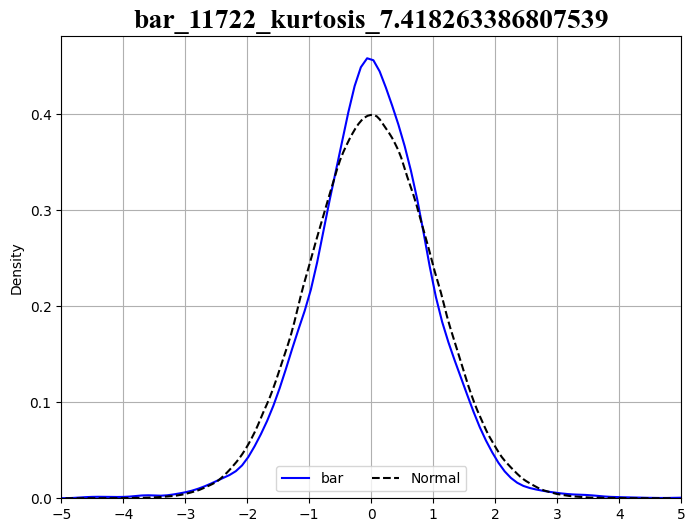

In [18]:
from custom_indicators.utils.plot import plot_kde

assert len(candles[150:]) == len(df)

"""
threshold:
0.7907317146647048
0.916133494307828
"""

merged_bar = build_bar_by_cumsum(
    candles[150:], df["threshold"].tolist(), 0.5632443315042106, reverse=False
)

plot_kde(merged_bar[:, 2])

In [3]:
import numpy as np
import optuna
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool
from scipy import stats  # noqa

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

# 尝试进一步迭代


def get_kurtosis(merged_bar):
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    df = numpy_candles_to_dataframe(candles)
    df["hlr"] = np.log(df["high"] / df["low"])
    log_n_1 = trial.suggest_int("log_n_1", 50, 150)
    df[f"r{log_n_1}"] = np.log(df["close"] / df["close"].shift(log_n_1))
    log_n_2 = trial.suggest_int("log_n_2", 5, 75)
    df[f"r{log_n_2}"] = np.log(df["close"] / df["close"].shift(log_n_2))

    # entropy
    entropy_n = trial.suggest_int("entropy_n", 30, 200)
    log_ret_list = log_ret(candles, [entropy_n] * len(candles))
    with WorkerPool() as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    df[f"en_{entropy_n}"] = entropy_array

    na_max = df.isna().sum().max()
    df = df.iloc[na_max:]

    threshold_part1 = df[["hlr", f"en_{entropy_n}"]].min(axis=1)
    threshold_part2 = df[[f"r{log_n_1}", f"r{log_n_2}"]].abs().min(axis=1)
    df["threshold"] = pd.concat([threshold_part1, threshold_part2], axis=1).max(axis=1)

    threshold_min = df["threshold"].sum() / (len(candles) // 60)
    threshold_max = df["threshold"].sum() / (len(candles) // 250)
    threshold = trial.suggest_float("threshold", threshold_min, threshold_max)

    len_gap = len(candles) - len(df)
    candles = candles[len_gap:]
    assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
    merged_bar = build_bar_by_cumsum(
        candles, df["threshold"].tolist(), threshold, reverse=False
    )

    # kurtosis
    kurtosis_all = get_kurtosis(merged_bar)
    kurtosis_2023 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2022-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2023-06-01"))
        ]
    )
    kurtosis_2024 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2023-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2024-06-01"))
        ]
    )
    kurtosis_2025 = get_kurtosis(
        merged_bar[
            (date_to_timestamp("2024-06-01") <= merged_bar[:, 0])
            & (merged_bar[:, 0] <= date_to_timestamp("2025-06-01"))
        ]
    )
    final_kurtosis = (kurtosis_all + kurtosis_2023 + kurtosis_2024 + kurtosis_2025) / 4

    return final_kurtosis


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-06-02 21:42:12,804] A new study created in memory with name: no-name-30ba94db-03cd-4abf-9a88-042d02132f6d
[I 2025-06-02 21:43:12,642] Trial 0 finished with value: 9.209601380899002 and parameters: {'log_n_1': 102, 'log_n_2': 69, 'entropy_n': 95, 'threshold': 0.38186177570350066}. Best is trial 0 with value: 9.209601380899002.
[I 2025-06-02 21:44:05,400] Trial 1 finished with value: 5.6699461594096405 and parameters: {'log_n_1': 109, 'log_n_2': 32, 'entropy_n': 66, 'threshold': 0.43332800352573464}. Best is trial 1 with value: 5.6699461594096405.
[I 2025-06-02 21:45:03,254] Trial 2 finished with value: 7.1091206628737105 and parameters: {'log_n_1': 107, 'log_n_2': 66, 'entropy_n': 129, 'threshold': 0.6585200706990614}. Best is trial 1 with value: 5.6699461594096405.
[I 2025-06-02 21:45:57,099] Trial 3 finished with value: 10.940917850306242 and parameters: {'log_n_1': 94, 'log_n_2': 41, 'entropy_n': 65, 'threshold': 0.2681489355667511}. Best is trial 1 with value: 5.669946159409

In [4]:
study.best_params

{'log_n_1': 52,
 'log_n_2': 23,
 'entropy_n': 180,
 'threshold': 0.5565096131615984}

In [4]:
import numpy as np
import optuna

from custom_indicators.toolbox.bar.fusion.v1 import FusionBarContainerV1


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    bar_container = FusionBarContainerV1()
    bar_container.SHORT_N = trial.suggest_int("short_log_n", 1, 100)
    bar_container.LONG_N = trial.suggest_int(
        "long_log_n", max(bar_container.SHORT_N + 1, 30), 300
    )
    bar_container.ENTROPY_N = trial.suggest_int(
        "rn_entropy", 25, bar_container.LONG_N - 1
    )
    bar_container.THRESHOLD = trial.suggest_float("threshold", 0.0, 1.0)
    bar_container.update_with_candles(candles)
    merged_bar = bar_container.get_fusion_bars()
    if len(merged_bar) < len(candles) // 300:
        return 1000
    return stats.kurtosis(merged_bar[:, 2], axis=None, fisher=False, nan_policy="omit")


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-06-01 00:33:10,354] A new study created in memory with name: no-name-a9b595fb-d034-4ebe-805e-aa2777d531e3
[I 2025-06-01 00:34:09,547] Trial 0 finished with value: 1000.0 and parameters: {'short_log_n': 23, 'long_log_n': 232, 'rn_entropy': 67, 'threshold': 0.9706500801237098}. Best is trial 0 with value: 1000.0.
[I 2025-06-01 00:34:56,409] Trial 1 finished with value: 3.0191094404703516 and parameters: {'short_log_n': 10, 'long_log_n': 196, 'rn_entropy': 45, 'threshold': 0.17622908392528447}. Best is trial 1 with value: 3.0191094404703516.
[I 2025-06-01 00:36:06,891] Trial 2 finished with value: 2.8930195789290565 and parameters: {'short_log_n': 64, 'long_log_n': 295, 'rn_entropy': 221, 'threshold': 0.7487661209398284}. Best is trial 2 with value: 2.8930195789290565.
[I 2025-06-01 00:36:53,093] Trial 3 finished with value: 3.03228432155669 and parameters: {'short_log_n': 29, 'long_log_n': 187, 'rn_entropy': 45, 'threshold': 0.6037140855938129}. Best is trial 2 with value: 2.8930

KeyboardInterrupt: 

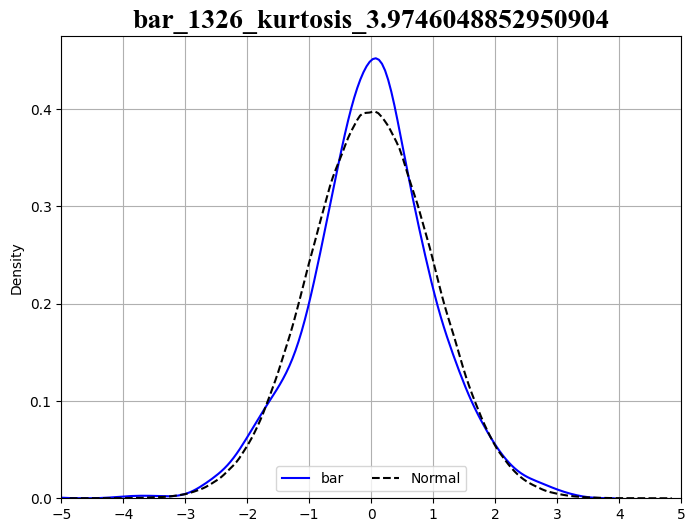

In [ ]:
from jesse import helpers, research

from custom_indicators.utils.plot import plot_kde

"""
SHORT_N = 21
LONG_N = 180
ENTROPY_N = 34
THRESHOLD = 0.8548507667918396
"""

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2024-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

bar_container = FusionBarContainerV1()
bar_container.SHORT_N = 21
bar_container.LONG_N = 180
bar_container.ENTROPY_N = 34
bar_container.THRESHOLD = 0.8548507667918396
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()

plot_kde(merged_bar[:, 2])

In [ ]:
"""
min(abs(short_log_n), add(long_log_n, rn_entropy))
{'short_log_n': 21,
 'long_log_n': 180,
 'rn_entropy': 34,
 'threshold': 0.8548507667918396}

 
"""

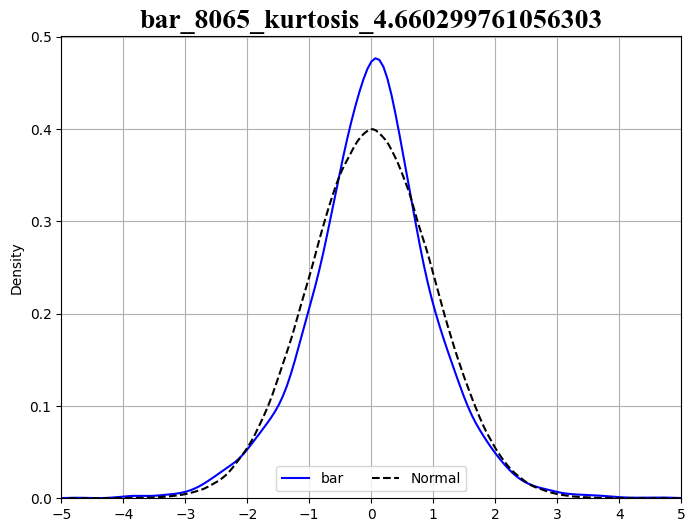

In [24]:
import os

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-31"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
print(candles.shape)
candles = candles[candles[:, 5] > 0]
df = numpy_candles_to_dataframe(candles)
# short log ret
short_log_n = 21
df[f"r{short_log_n}"] = np.log(df["close"] / df["close"].shift(short_log_n))

# long log ret
long_log_n = 180
df[f"r{long_log_n}"] = np.log(df["close"] / df["close"].shift(long_log_n))

# entropy
entropy_n = 34
log_ret_list = log_ret(candles, entropy_n)
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)
len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df[f"en_{entropy_n}"] = entropy_array

na_max = df.isna().sum().max()
df = df.iloc[na_max:]

df["threshold"] = [
    min(x, y)
    for x, y in zip(
        np.abs(df[f"r{short_log_n}"]).tolist(),
        (df[f"r{long_log_n}"] + df[f"en_{entropy_n}"]).tolist(),
    )
]

threshold = 0.8548507667918396

len_gap = len(candles) - len(df)
candles = candles[len_gap:]
assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
merged_bar = build_bar_by_cumsum(
    candles, df["threshold"].tolist(), threshold, reverse=False
)

from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

In [ ]:
bar_container = FusionBarContainerV1()
thresholds = bar_container._get_thresholds(candles)

In [31]:
len(candles) - len(df)

0

In [26]:
df["threshold"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00    0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: threshold, Length: 2846501, dtype: float64

In [37]:
(df["threshold"].iloc[180:] - thresholds).sum()

0.0

In [18]:
df["close"]

2020-01-01 03:34:00      7238.46
2020-01-01 03:35:00      7236.59
2020-01-01 03:36:00      7227.47
2020-01-01 03:37:00      7224.86
2020-01-01 03:38:00      7222.34
                         ...    
2025-05-30 23:55:00    103999.00
2025-05-30 23:56:00    103992.60
2025-05-30 23:57:00    103915.90
2025-05-30 23:58:00    103932.90
2025-05-30 23:59:00    103950.00
Name: close, Length: 2846501, dtype: float64

In [17]:
df["r21"]

2020-01-01 03:34:00    0.002127
2020-01-01 03:35:00    0.001942
2020-01-01 03:36:00    0.000540
2020-01-01 03:37:00    0.000082
2020-01-01 03:38:00   -0.001046
                         ...   
2025-05-30 23:55:00    0.002473
2025-05-30 23:56:00    0.003039
2025-05-30 23:57:00    0.000402
2025-05-30 23:58:00    0.001216
2025-05-30 23:59:00    0.002361
Name: r21, Length: 2846501, dtype: float64

In [16]:
log_ret_short_n = np.log(candles[21:, 2] / candles[:-21, 2])[180 - 21 :]
log_ret_short_n[0]

6.228567673667354e-05

In [1]:
import numpy as np
from jesse import helpers, research

candles = np.load("data/btc_1m.npy")
candles.shape

(2831040, 6)

In [2]:
from mpire import WorkerPool

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

SHORT_N = 21
LONG_N = 180
ENTROPY_N = 34
THRESHOLD = 0.8548507667918396

_unfinished_bars_timestamps = None
_unfinished_bars_thresholds = None
_merged_bars = None


def get_thresholds(candles_: np.ndarray) -> np.ndarray:
    log_ret_short_n = np.log(candles_[SHORT_N:, 2] / candles_[:-SHORT_N, 2])[
        LONG_N - SHORT_N :
    ]

    log_ret_long_n = np.log(candles_[LONG_N:, 2] / candles_[:-LONG_N, 2])
    entropy_log_ret_list = log_ret(candles_[LONG_N - ENTROPY_N :, :], ENTROPY_N)
    with WorkerPool() as pool:
        entropy_array = pool.map(sample_entropy_numba, entropy_log_ret_list)
    del entropy_log_ret_list

    return np.min([np.abs(log_ret_short_n), log_ret_long_n + entropy_array], axis=0)


# 初始化
init_candles = candles[candles[:, 5] > 0][:-10000]
thresholds = get_thresholds(init_candles)
init_candles = init_candles[len(init_candles) - len(thresholds) :]
_merged_bars = build_bar_by_cumsum(candles, thresholds, THRESHOLD, reverse=False)

_unfinished_bars_timestamps = init_candles[:, 0].astype(int)[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]
_unfinished_bars_thresholds = thresholds[
    init_candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
]

In [7]:
update_candles = candles[:-9999]
anchor_index_array = np.where(
    candles[:, 0].astype(int) > _merged_bars[-1, 0].astype(int)
)[0]
anchor_index = anchor_index_array[0] - LONG_N
update_candles = update_candles[anchor_index:]
update_thresholds = get_thresholds(update_candles)
all_thresholds = np.hstack([_unfinished_bars_thresholds, update_thresholds])
len(all_thresholds)

1423

In [10]:
all_unfinished_candles = candles[:-9999][
    candles[:-9999][:, 0].astype(int) > _unfinished_bars_timestamps[0]
]
all_unfinished_candles.shape

(711, 6)